Calcula Curvatura 

In [31]:
import numpy as np
from matplotlib import pyplot as plt
from collections import deque
import math

In [32]:
sigma=100
t = np.arange(x.shape[-1])
 
tresh=0.4    #analisar (automatizar...)

eta = .1
n = 512
t = np.arange(512)/512. * np.pi
x = np.sin(2*t)  + eta*0.2*np.random.rand(n)
y = np.cos(3*t)  + eta*np.random.rand(n)

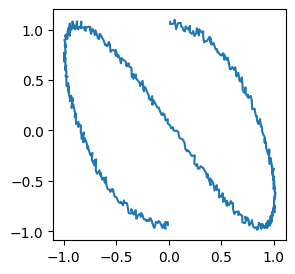

In [33]:
plt.figure(figsize=(3,3))
plt.plot(x, y)

In [34]:
# Função filtro gauss:
def gaus_filter(n, n_median, sig):
   # n: numero de dados
   #n_median: posição para o vr maximo da curva de Gaus (ex. n/2) 
   #sigma: desvio padrão da gausiana
   gaus_f = np.zeros(n, dtype = complex)   
   for i in np.arange(n):
      gaus_f[i] = (1./(sig*(np.sqrt(2*np.pi))))*np.exp((-1*(i- n_median)**2)/(2*sig**2))
   return gaus_f
 
# Calcula o espectro de energia do vetor transformado antes da gaussina
def total_energy(fft_x):
   real = np.real(fft_x)**2
   imag = np.imag(fft_x)**2
   return (real + imag)

def calc_energy(tf):
    et = np.zeros(tf.shape[0], dtype = np.float64)
    for i in np.arange(tf.shape[0]):
        et[i] = (np.real(tf[i])**2) + (np.imag(tf[i])**2) 
    return et, np.sum(et)

def gaus_smooth_signal (x, sigma):
   n = x.shape[-1]
   gaus_f = gaus_filter(n, n/2, sigma)
   trans_gaus = np.fft.fft(gaus_f)
   trans_x=(np.fft.fft(x))
   trans_x = trans_x * trans_gaus
   itrans_x = np.fft.fftshift(np.fft.ifft(trans_x))
   return (itrans_x, gaus_f) 

# Calcula x'(t),x''(t), y'(t), y''(t), a partir de Fourier:
def derivatives(fft_x, freqs_x):   
   dx =  freqs_x*1j
   dx2 = dx**2
   dF = np.fft.fftshift(np.fft.ifft(fft_x*dx))
   d2F= np.fft.fftshift(np.fft.ifft(fft_x*dx2))
   return ((dF), (d2F))

# Calcula FFT e frequencias  
def fft_freqs(x):
   return (np.fft.fft(x), np.fft.fftfreq(x.shape[-1]))

# Calcula Curvatures
def curvatures(dx, dx2, dy, dy2):
   t = np.arange(dx.shape[-1])
   n= (dx[t]*dy2[t]) - (dy[t]*dx2[t])
   d= ((dx[t]**2) + (dy[t]**2))**(3.0/2)
   return (n/d) 



In [35]:

# --- Calc curvatures
x_smooth, gaus_f = gaus_smooth_signal(x, 5)
y_smooth, gaus_f = gaus_smooth_signal(y, 5)

# Calcula x'(t),x''(t), y'(t), y''(t), a partir das transformadas:
fft_x, freqs = fft_freqs(x_smooth)
energy_x = total_energy(fft_x)
dx, dx2 = derivatives(fft_x, freqs)

fft_y, freqs = fft_freqs(y_smooth)
energy_y = total_energy(fft_y)
dy, dy2 = derivatives(fft_y, freqs)

curvs = curvatures(dx, dx2, dy, dy2)
m_curvs = np.abs(curvs)
fft_curvs, freqs = fft_freqs(m_curvs)
dK, d2K = derivatives(fft_curvs, freqs)
# Busca pelos pontos máximos de curvatura
## Pontos de máximo - d2K/ds < 0:
zero_cross= deque()
max_points_mcurv= deque()
d1 = np.real(dK)
d2 = np.real(d2K)
for t in np.arange(n):
   if t < (n-1):
      if (np.sign(d1[t]) != np.sign(d1[t+1])):   
           zero_cross.appendleft(t)
           if (d2K[t] <0):
               max_points_mcurv.appendleft(t)
           elif (d2[t+1] <0):
               max_points_mcurv.appendleft(t+1)

 


c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:895: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))


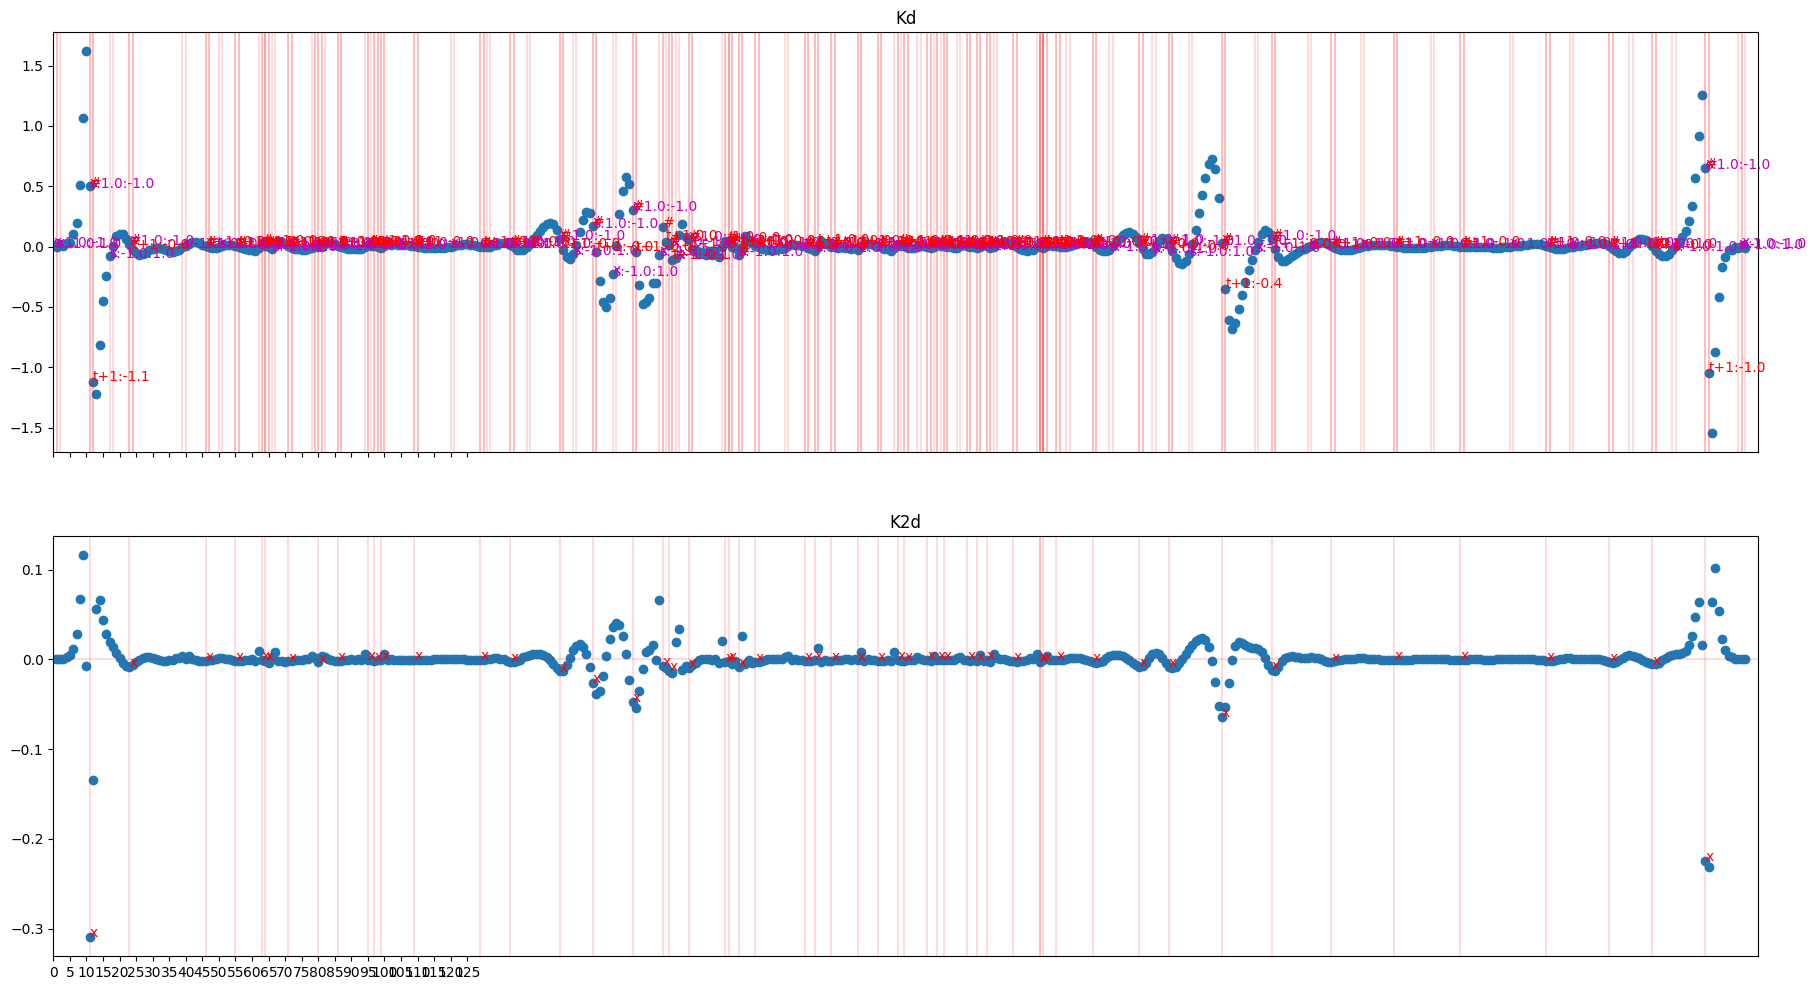

In [36]:
t = np.arange(dK.shape[-1])
fig, axis = plt.subplots(2, 1, figsize=(22,12), sharex=True)
axis[0].scatter(t, dK)
axis[0].set( title = 'Kd', xlim=(n-3, n+3), xticks=(np.arange(0, 128, 5))) 
for t1 in zero_cross:
    axis[0].text(t1, dK[t1], 'x', color='m') 
    axis[0].text(t1, np.real(dK[t1]-0.01), "s:{:.1f}:{:.1f}".format(np.sign(np.real(dK[t1])), \
                                     np.sign(np.real(dK[t1+1]))), color='m') 
    axis[0].axvline(t1,0,1, linewidth = 0.2, color='r') 
    axis[0].axvline(t1+1,0,1, linewidth = 0.2, color='r') 
for t2 in max_points_mcurv:
    axis[0].text(t2, dK[t2], '#', color='r') 
    axis[0].text(t2+1, np.real(dK[t2+1]+0.01), "t+1:{:.1f}".format(np.real(dK[t2+1])), color='r') 
    axis[0].axvline(t2,0,1, linewidth = 0.2, color='r') 
    axis[0].axvline(t2+1,0,1, linewidth = 0.2, color='r') 
 
axis[0].axhline(0,0,1, linewidth = 0.2, color='r') 

axis[1].scatter(t, d2K)
axis[1].set( title = 'K2d') 
for t2 in max_points_mcurv:
    axis[1].text(t2, d2K[t2], 'x', color='r') 
    axis[1].axvline(t2,0,1, linewidth = 0.2, color='r') 
axis[1].axhline(0,0,1, linewidth = 0.2, color='r') 
t = np.arange(gaus_f.shape[-1])
# get the first element of max_points_mcurv
first = max_points_mcurv.pop()  #remove from head of queue
max_points_mcurv.append(first)  #insert from head of queue
last = max_points_mcurv.popleft()  #remove from head of queue
max_points_mcurv.appendleft(last)  #insert from head of queue


c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:753: ComplexWarning: Casting complex values to real di

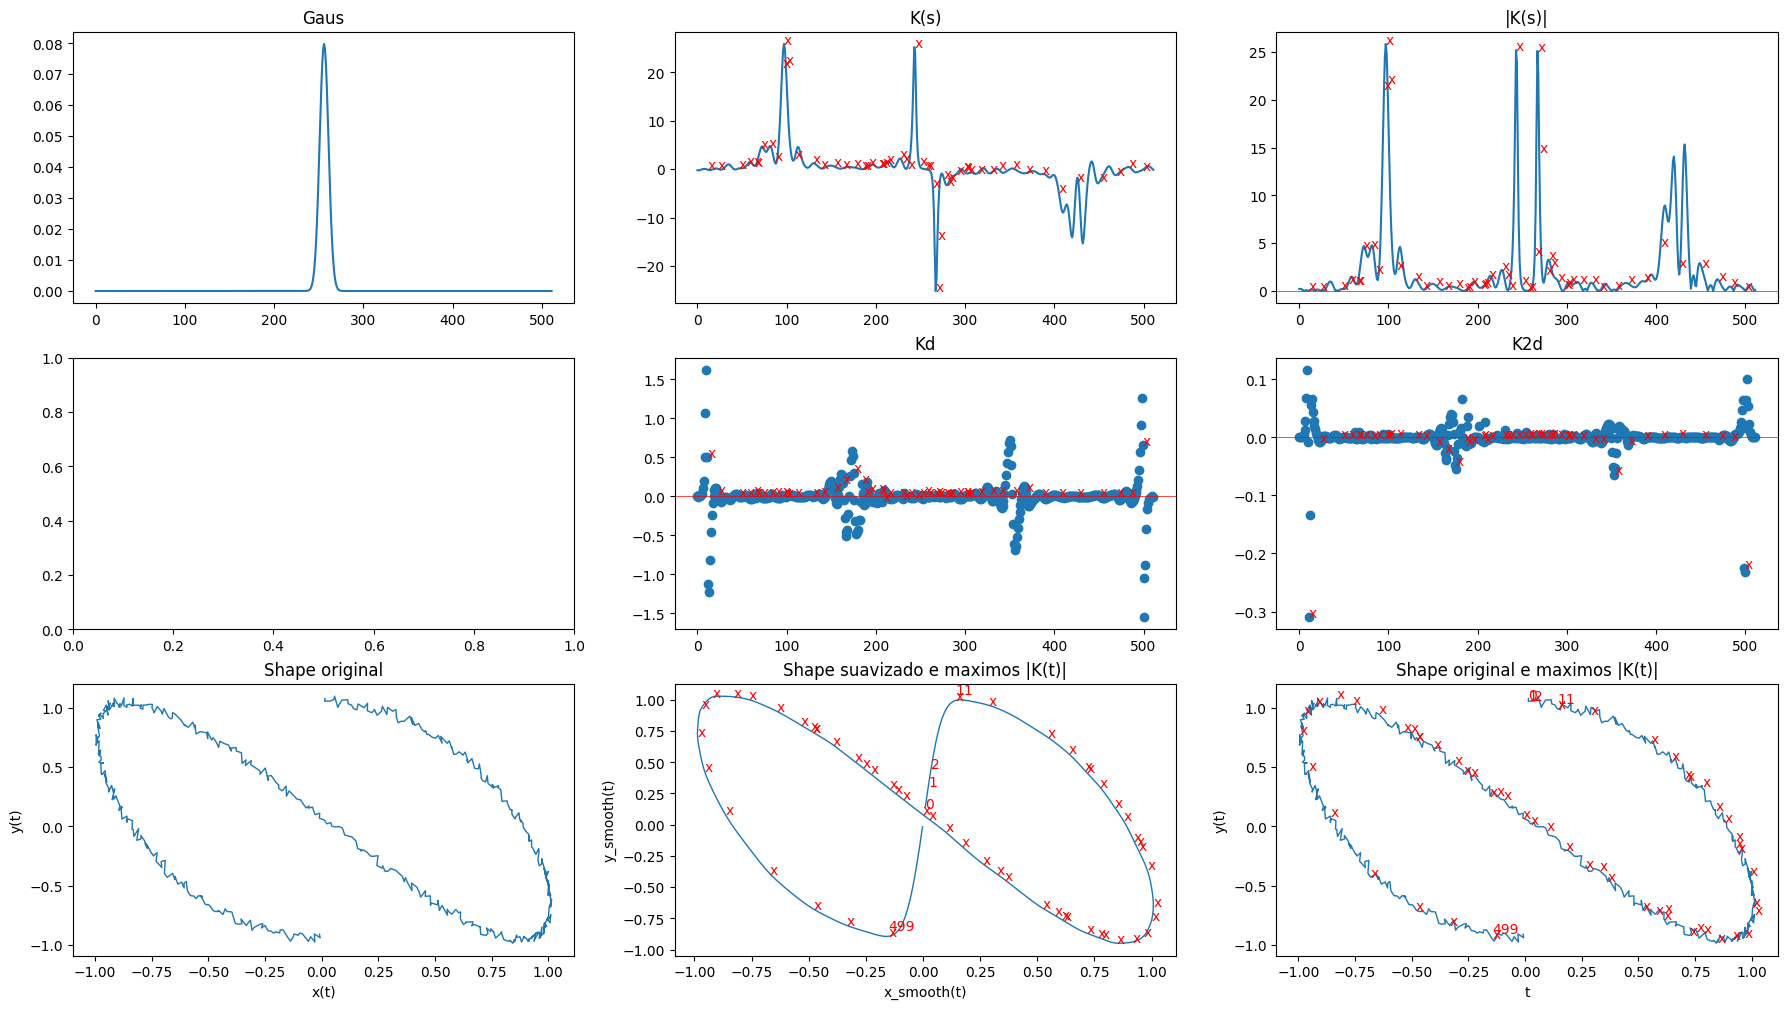

In [39]:

fig,axis = plt.subplots(3, 3, figsize=(22,12))
axis[0,0].plot(t, gaus_f)
axis[0,0].set( title = 'Gaus')

axis[0,1].plot(t, curvs)
axis[0,1].set( title = 'K(s)') 
for t2 in max_points_mcurv:
    axis[0,1].text(t2, curvs[t2], 'x', color='r') 

axis[0,2].plot(t, m_curvs)
axis[0,2].set( title = '|K(s)|') 
axis[0,2].axhline(0,0,1, linewidth = 0.5, color='r') 
for t2 in max_points_mcurv:
    axis[0,2].text(t2, m_curvs[t2], 'x', color='r') 

axis[1,1].scatter(t, dK)
axis[1,1].set( title = 'Kd') 
for t2 in max_points_mcurv:
    axis[1,1].text(t2, dK[t2], 'x', color='r') 
axis[1,1].axhline(0,0,1, linewidth = 0.5, color='r') 

axis[1,2].scatter(t, d2K)
axis[1,2].set( title = 'K2d') 
for t2 in max_points_mcurv:
    axis[1,2].text(t2, d2K[t2], 'x', color='r') 
axis[1,2].axhline(0,0,1, linewidth = 0.5, color='r') 
axis[2,0].plot(x, y,  linewidth=1.0)
axis[2,0].set( #xlim=(np.real(trix)-3, np.real(triy)+3), xticks=np.arange(np.real(trix), np.real(triy), 10), \
       xlabel= 'x(t)', ylabel = 'y(t)', title = 'Shape original')

axis[2,1].plot(x_smooth, y_smooth,  linewidth=1.0)
axis[2,1].set( #xlim=(np.real(trix)-3, np.real(triy)+3), xticks=np.arange(np.real(trix), np.real(triy), 10), \
       xlabel= 'x_smooth(t)', ylabel = 'y_smooth(t)', title = 'Shape suavizado e maximos |K(t)|')
for t2 in max_points_mcurv:
    axis[2,1].text(x_smooth[t2], y_smooth[t2], 'x', color='r') 
axis[2,1].text(x_smooth[0], y_smooth[0]-0.01, '0', color='r')   
axis[2,1].text(x_smooth[1], y_smooth[1]+0.01, '1', color='r')
axis[2,1].text(x_smooth[2], y_smooth[2]+0.01, '2', color='r')
axis[2,1].text(x_smooth[first], y_smooth[first]+0.05, first, color='r')
axis[2,1].text(x_smooth[last], y_smooth[last]+0.05, last, color='r')
#axis[1].axhline(0,0,1, linewidth = 0.5, color='r') 

axis[2,2].plot(x, y,  linewidth=1.0) 
axis[2,2].set( #xlim=(np.real(trix)-3, np.real(triy)+3), xticks=np.arange(np.real(trix), np.real(triy), 10), \
       xlabel= 't', ylabel = 'y(t)', title = 'Shape original e maximos |K(t)|')
for t2 in max_points_mcurv:
    axis[2,2].text(x[t2], y[t2], 'x', color='r') 
axis[2,2].text(x[0], y[0]-0.01, '0', color='r')   
axis[2,2].text(x[1], y[1]+0.01, '1', color='r')
axis[2,2].text(x[2], y[2]+0.01, '2', color='r')
axis[2,2].text(x[first], y[first]+0.05, first, color='r')
axis[2,2].text(x[last], y[last]+0.05, last, color='r')    
plt.show()

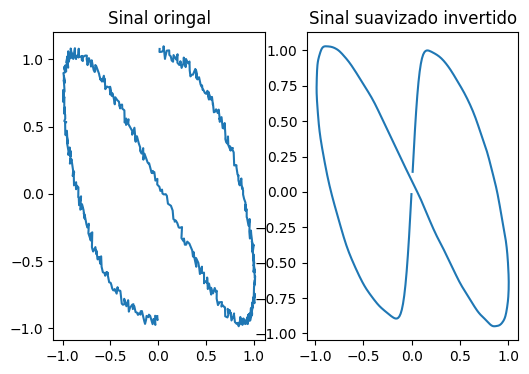

In [38]:

# Shape após suavização:

fig, axis = plt.subplots(1, 2, figsize=(6,4))
axis[0].plot(x, y )
axis[0].set( title = 'Sinal oringal') 

axis[1].plot(x_smooth, y_smooth)
axis[1].set( title = 'Sinal suavizado invertido') 
 
plt.show()